# FX Leverage Carry-Trade

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import carry_trade as ct
import datetime as dt

from date_function_v2 import holiday_adjust

matplotlib.rcParams[ 'figure.figsize' ] = ( 16, 9 )

## 1. Load data

In [2]:
data_path = 'Final_Data/Final_sorted.csv'
final_data = pd.read_csv(data_path)

In [3]:
final_data = final_data.set_index('Date')
final_data.index = pd.to_datetime(final_data.index)

In [4]:
final_data.columns

Index(['GBP_Spot', 'GBP_1W', 'GBP_1M', 'GBP_2M', 'GBP_LIBOR_1W',
       'GBP_LIBOR_1M', 'GBP_LIBOR_2M', 'AUD_Spot', 'AUD_1M', 'AUD_2M',
       'AUD_LIBOR_1M', 'AUD_LIBOR_2M', 'USD_Spot', 'USD_1W', 'USD_1M',
       'USD_2M', 'USD_LIBOR_1W', 'USD_LIBOR_1M', 'USD_LIBOR_2M',
       'JPY_LIBOR_1W', 'JPY_LIBOR_1M', 'JPY_LIBOR_2M'],
      dtype='object')

## 2. Implement Strategy 

In [5]:
# if you want to test single currency or single trading period, just modify the following list

fx_list = ['USD', 'AUD', 'GBP']
period_list = [7, 30, 60]

In [6]:
results = ct.algo_loop(final_data, fx_list, period_list, leverage = 2.0)

2019-11-17 11:04:57:770582: Beginning Carry-Trade Strategy run


/Users/trevor/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


2019-11-17 11:05:25:669697: Algo run complete.


In [ ]:
results.to_csv('Results/results.csv')

In [7]:
results

,Signal,FX_name,Period,Foreign_IR,Domestic_IR,FX_Rate,Equity,Asset Pos,Unreal_Return,Real_Return
Date,,,,,,,,,,
2007-09-21,0.00978355,AUD,2M,0.06835,0.0089625,100.089,10000,20000,0.0212896,0
2007-09-24,0.00973962,AUD,2M,0.06835,0.0089625,99.7,10000,20000,0.013428,0
2007-09-25,0.00975187,AUD,2M,0.06835,0.0089625,100.223,10000,20000,0.0239977,0
2007-09-26,0.00974128,AUD,2M,0.06835,0.0089625,101.295,10000,20000,0.0456627,0
2007-09-27,0.00977635,AUD,2M,0.06835,0.0089625,101.753,10000,20000,0.0549188,0
...,...,...,...,...,...,...,...,...,...,...
2019-11-05,0.00321073,USD,2M,0.0196738,-0.00098,109.16,15918.4,31836.9,0.012251,0.591844
2019-11-06,0.00318966,USD,2M,0.0196738,-0.00098,108.98,15918.4,31836.9,0.00893316,0.591844
2019-11-07,0.00320777,USD,2M,0.0196738,-0.00098,109.28,15918.4,31836.9,0.0144629,0.591844


In [12]:
print('Avg Annual Return:' , (results['Real_Return'][-1] + 1)**(1/11) - 1 )

Avg Annual Return: 0.04316882250636267


## 3. Analysis 

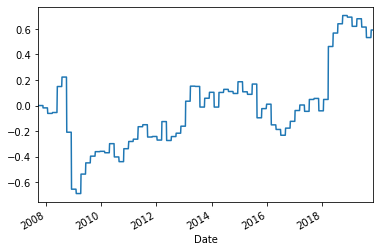

In [9]:
results['Real_Return'].plot()

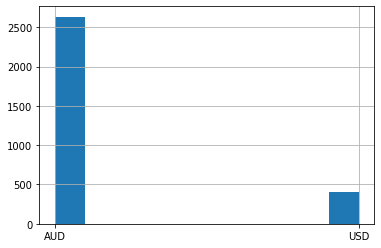

In [10]:
results['FX_name'].hist()

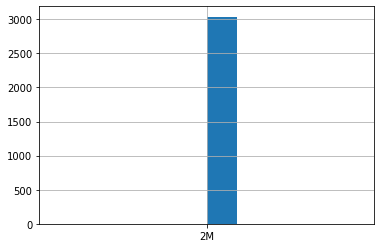

In [11]:
results['Period'].hist()